### Check influence of different parameters in performance. 

Check influence of:
- specifying different chunk sizes and chunking along different dimensions
- use already standardized data --> does it save memory?
- use ``` .persist()``` to load data in a distributed way and speed up reading



In [1]:
chunk_size = 521#483*2 #483

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp
import random

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps, init_device
from modules.data import WeatherBenchDatasetXarrayHealpix
from modules.healpix_models import UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix
from modules.test import compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg_nearest/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
lead_time = 6
out_features = 2
nb_timesteps = 2
len_sqce = 2
# define time resolution
delta_t = 6

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,4"
gpu = [0,1]
num_workers = 10
pin_memory = True
batch_size = 95

nb_epochs = 10
learning_rate = 8e-3

#obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords', chunks={'time':483})
#rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

In [5]:
from modules.data import WeatherBenchDatasetIterative
class WeatherBenchDatasetXarrayHealpixTemp(Dataset):
    
    """ Dataset used for graph models (1D), where data is loaded from stored numpy arrays.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    out_features : int
        Number of output features
    delta_t : int
        Temporal spacing between samples in temporal sequence (in hours)
    len_sqce : int
        Length of the input and output (predicted) sequences
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
        
    def __init__(self, ds, out_features, delta_t, len_sqce, years, nodes, nb_timesteps, 
                 max_lead_time=None, load=True, mean=None, std=None):
        
        
        self.delta_t = delta_t
        self.len_sqce = len_sqce
        self.years = years
        
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        self.in_features = self.data.shape[-1]
        
        self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        eps = 0.001 #add to std to avoid division by 0
        
        # Count total number of samples
        total_samples = self.data.shape[0]        
        
        if max_lead_time is None:
            self.n_samples = total_samples - (len_sqce+1) * delta_t
        else:
            self.n_samples = total_samples - (len_sqce+1) * delta_t - max_lead_time
        
        # Normalize
        self.data = (self.data - self.mean.to_array(dim='level')) / (self.std.to_array(dim='level') + eps)
        self.data.persist()
        
        self.idxs = np.array(range(self.n_samples))
        
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, len_sqce, n_features]
            
        """
        idx_data = idx#self.idxs[idx]
        #1,0,2
        
        #batch[0] --> (batch_size, num_nodes, n_features*len_sq)
        idx_full = np.concatenate([idx_data+delta_t,  idx_data + delta_t * len_sqce, idx_data + delta_t * (len_sqce+1)])
        dat = self.data.isel(time=idx_full).values
        
        
        X = (
            torch.tensor(dat[:len(idx),:,:] , \
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),
        )
        
        y = (torch.tensor(dat[len(idx):len(idx)*2,:,:],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),\
             torch.tensor(dat[len(idx)*2:,:,:out_features],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1)
        
        )
        return X, y 

```standardization_contants``` is a boolean that will enable the creation of a file that contains the constants already standardized. Set to True only if it is the first time executing the notebook or the file was lost. 

In [6]:
standardization_contants = False

In [7]:
if standardization_contants:
    constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg.nc').rename({'orography' :'orog'})
    constants = constants.assign(cos_lon=lambda x: np.cos(np.deg2rad(x.lon)))
    constants = constants.assign(sin_lon=lambda x: np.sin(np.deg2rad(x.lon)))
    
    constants_mean = constants.mean().compute()
    constants_std = constants.std().compute()
    
    constants_mean.to_netcdf(f'{input_dir}constants/mean.nc')
    constants_std.to_netcdf(f'{input_dir}constants/std.nc')
    
    c_mean = xr.open_dataset(f'{input_dir}constants/mean.nc')
    c_std = xr.open_dataset(f'{input_dir}constants/std.nc')
    
    constants_ss = (constants - c_mean)/c_std
    
    constants_ss.to_netcdf(f'{input_dir}constants/constants_5.625deg_standardized.nc')

In [8]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords', chunks={'time':chunk_size}).rename({'z':'z500'})
t850 = xr.open_mfdataset(f'{input_dir}temperature_850/*.nc', combine='by_coords', chunks={'time':chunk_size}).rename({'t':'t850'})
rad = xr.open_mfdataset(f'{input_dir}toa_incident_solar_radiation/*.nc', combine='by_coords', chunks={'time':chunk_size})

z500 = z500.isel(time=slice(7, None))
t850 = t850.isel(time=slice(7, None))

constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg_standardized.nc')
#constants = constants.assign(cos_lon=lambda x: np.cos(np.deg2rad(x.lon)))
#constants = constants.assign(sin_lon=lambda x: np.sin(np.deg2rad(x.lon)))

#temp = xr.DataArray(np.zeros(z500.dims['time']), coords=[('time', z500.time.values)])
#constants, _ = xr.broadcast(constants, temp)

orog = constants['orog']
lsm = constants['lsm']
lats = constants['lat2d']
slt = constants['slt']
cos_lon = constants['cos_lon']
sin_lon = constants['sin_lon']

num_constants = len([orog, lats, lsm, slt])
constants_tensor = torch.tensor(xr.merge([orog, lats, lsm, slt], compat='override').to_array().values, \
                            dtype=torch.float)

In [9]:
#description = "no_const"
description = "all_const"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

# z500, t850, orog, lats, lsm, slt, rad
#feature_idx = [0, 1]
in_features = 7 #len(feature_idx)
ds = xr.merge([z500, t850, rad], compat='override')
#ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*val_years))
ds_test = ds.sel(time=slice(*test_years))


In [10]:
if standardization_contants:
    mean_features = ds_train.mean(('time','node')).compute()
    std_features = ds_train.std('time').mean('node').compute()

    mean_features.to_netcdf(f'{input_dir}mean_train_features_dynamic.nc')
    std_features.to_netcdf(f'{input_dir}std_train_features_dynamic.nc')


In [11]:
train_mean_ = xr.open_mfdataset(f'{input_dir}mean_train_features_dynamic.nc')
train_std_ = xr.open_mfdataset(f'{input_dir}std_train_features_dynamic.nc')

In [12]:
# Train and validation data
training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features, delta_t=delta_t,
                                                   len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                   years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                   mean=train_mean_, std=train_std_, load=False)
validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, delta_t=delta_t,
                                                     len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                     years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                     mean=train_mean_, std=train_std_, load=False)

dl_train = DataLoader(training_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,\
                      pin_memory=pin_memory)

dl_val = DataLoader(validation_ds, batch_size=batch_size*2, shuffle=False, num_workers=num_workers,\
                    pin_memory=pin_memory)

In [13]:
# Model #old: in_channels=in_features*len_sqce
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=in_features, out_channels=out_features, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

In [14]:
torch.cuda.empty_cache()

In [15]:
def train_model_2steps_custom(model, device, training_ds, constants, batch_size, epochs, lr, validation_ds):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    train_losses = []
    val_losses = []
    n_samples = training_ds.n_samples
    n_samples_val = validation_ds.n_samples
    num_nodes = training_ds.nodes
    num_constants = constants.shape[1]
    out_features = training_ds.out_features
    
    constants_expanded = constants.expand(batch_size, num_nodes, num_constants)
    constants1 = constants_expanded.to(device)
    idxs_val = validation_ds.idxs
    
    for epoch in range(epochs):
        
        print('\rEpoch : {}'.format(epoch), end="")
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        
        random.shuffle(training_ds.idxs)
        idxs = training_ds.idxs
        
        batch_idx = 0
        
        for i in range(0, n_samples - batch_size, batch_size):
            i_next = min(i + batch_size, n_samples)
            
            if len(idxs[i:i_next]) < batch_size:
                constants_expanded = contants.expand(len(idxs[i:i_next]), num_nodes, num_constants)
                constants1 = constants_expanded.to(device)
        
            
            #t1 = time.time()
            batch, labels = training_ds[idxs[i:i_next]]
            
            #t2 = time.time()
            
            # Transfer to GPU
            
            
            batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
            label1 = labels[0].to(device)
            label2 = labels[1].to(device)
            
            
            #t3 = time.time()
            batch_size = batch1.shape[0]
            
            # Model
            
            #t4 = time.time()
            output1 = model(batch1)  
            #t5 = time.time()
            batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
            #t6 = time.time()
            output2 = model(batch2)
            #t7 = time.time()
            loss = criterion(output1, label1[:,:,:out_features]) + criterion(output2, label2)
            #t8 = time.time()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
            
            #print('\nTime to read batch: {}s'.format(t2-t1))
            #print('Time to transfer data to GPU: {}s'.format(t3-t2))
            #print('Time to process input 1: {}s'.format(t5-t4))
            #print('Time to process input 2: {}s'.format(t7-t6))
            #print('Time to compute loss: {}s'.format(t8-t7))
            #print('\n')
            print('\rBatch idx: {}; Loss: {:.3f}'.format(batch_idx, train_loss/(batch_size*(batch_idx+1))), end="")
            batch_idx += 1
        
        train_loss = train_loss / n_samples
        train_losses.append(train_loss)
        
        model.eval()
        
        constants1 = constants_expanded.to(device)
        with torch.set_grad_enabled(False):
            index = 0
            
            for i in range(0, n_samples_val - batch_size, batch_size):
                i_next = min(i + batch_size, n_samples_val)

                if len(idxs_val[i:i_next]) < batch_size:
                    constants_expanded = contants.expand(len(idxs_val[i:i_next]), num_nodes, num_constants)
                    constants1 = constants_expanded.to(device)


                #t1 = time.time()
                batch, labels = validation_ds[idxs_val[i:i_next]]
                # Transfer to GPU
                batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]
                
                output1 = model(batch1)
                batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1[:,:,:out_features]).item() 
                                       + criterion(output2, label2).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / n_samples_val
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
        
    return train_losses, val_losses

In [16]:
train_model_2steps_custom(spherical_unet, device, training_ds, constants_tensor.transpose(1,0), batch_size, epochs=7, \
                                           lr=learning_rate, validation_ds=validation_ds)

Batch idx: 3134; Loss: 0.146Epoch:   1/  7  - loss: 0.146  - val_loss: 0.08996  - time: 9112.442816
Batch idx: 3134; Loss: 0.067Epoch:   2/  7  - loss: 0.067  - val_loss: 0.07784  - time: 8952.762427
Batch idx: 3134; Loss: 0.059Epoch:   3/  7  - loss: 0.059  - val_loss: 0.06506  - time: 9087.411525
Batch idx: 3134; Loss: 0.055Epoch:   4/  7  - loss: 0.055  - val_loss: 0.06146  - time: 9108.357737
Batch idx: 3134; Loss: 0.052Epoch:   5/  7  - loss: 0.052  - val_loss: 0.05875  - time: 9163.751619
Batch idx: 3134; Loss: 0.051Epoch:   6/  7  - loss: 0.051  - val_loss: 0.06549  - time: 8639.539581
Batch idx: 3134; Loss: 0.050Epoch:   7/  7  - loss: 0.050  - val_loss: 0.09280  - time: 7845.371900


([0.14609487630704313,
  0.06691656585619492,
  0.05884525018606003,
  0.05463608803415421,
  0.05232742307901584,
  0.05091046646963797,
  0.049796112792113253],
 [0.0899640527970213,
  0.07783917889697838,
  0.06505507764545217,
  0.06146494293280259,
  0.058750781663517763,
  0.06549294110768775,
  0.09280043438659136])

In [18]:
train_loss = [0.14609487630704313,
  0.06691656585619492,
  0.05884525018606003,
  0.05463608803415421,
  0.05232742307901584,
  0.05091046646963797,
  0.049796112792113253]

val_loss = [0.0899640527970213,
  0.07783917889697838,
  0.06505507764545217,
  0.06146494293280259,
  0.058750781663517763,
  0.06549294110768775,
  0.09280043438659136]

In [17]:
torch.save(spherical_unet.state_dict(), model_filename)

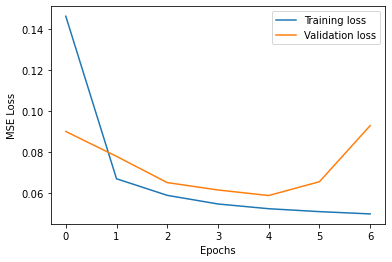

In [19]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [24]:
import netCDF4 as nc4

In [29]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords', chunks={'time':chunk_size}).rename({'z':'z500'})
print('compression level: ', z500['z500'].encoding.get('complevel', False))

compression level:  0
